In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# number of matches in upcoming week
n_matches = 7

In [3]:
df = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [4]:
spare = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [5]:
df.head(n_matches)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,1-Feb-20,Jaguares,Lions,0,0,1.24,25.47,4.08,10
1,1-Feb-20,Stormers,Hurricanes,0,0,1.74,21.37,2.14,10
2,1-Feb-20,Crusaders,Waratahs,0,0,1.08,35.60,7.45,10
3,1-Feb-20,Sunwolves,Rebels,0,0,6.60,34.41,1.10,10
4,31-Jan-20,Sharks,Bulls,0,0,1.52,20.82,2.57,10
5,31-Jan-20,Brumbies,Reds,0,0,1.38,23.08,3.07,10
6,31-Jan-20,Blues,Chiefs,0,0,2.29,22.19,1.64,10


### Get win streak

In [6]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Cleaning and Feature Engineering

In [7]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds',
             'home_country_ARG', 'home_country_JPN', 'away_country_ARG',
             'away_country_JPN', 'home_team_Cheetahs', 'away_team_Cheetahs',
             'home_team_Kings', 'away_team_Kings', 'home_team_Force',
             'away_team_Force'], 
            axis=1,
            inplace=True)
    
    return df

In [8]:
df = cleanup(df)
df.head(15)

,Bookmakers Surveyed,home_margin,home_win,home_streak,away_streak,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,10,0,False,6,-3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.766917
1,10,0,False,-1,-1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0.551546
2,10,0,False,4,-1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0.873388
3,10,0,False,-9,-1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.142857
4,10,0,False,-1,-1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.628362
5,10,0,False,8,-3,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0.689888
6,10,0,False,-1,-1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.417303
7,10,32,True,5,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.795222
8,10,4,True,3,6,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0.657277
9,10,24,True,2,-2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.829085


In [9]:
import seaborn as sns

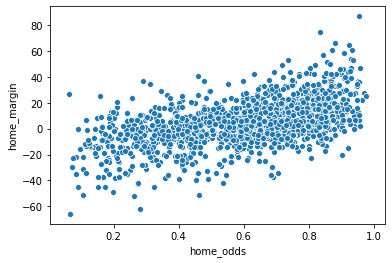

In [10]:
sns.scatterplot(x='home_odds', y='home_margin', data=df)

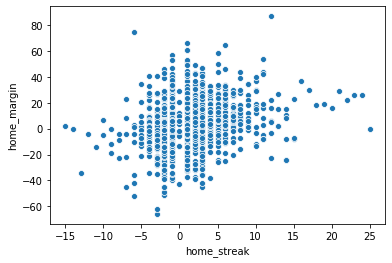

In [11]:
sns.scatterplot(x='home_streak', y='home_margin', data=df)

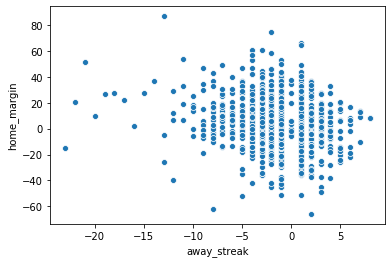

In [12]:
sns.scatterplot(x='away_streak', y='home_margin', data=df)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Bookmakers Surveyed,1351.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
home_margin,1351.0,4.349371,17.436214,-66.000000,-6.000000,5.000000,15.000000,87.000000
home_streak,1351.0,1.242783,3.989279,-15.000000,-1.000000,1.000000,3.000000,25.000000
away_streak,1351.0,-1.108808,3.381760,-23.000000,-3.000000,-1.000000,1.000000,8.000000
home_country_AUS,1351.0,0.295337,0.456363,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_NZ,1351.0,0.329386,0.470164,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_SA,1351.0,0.324944,0.468528,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_AUS,1351.0,0.296817,0.457024,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_NZ,1351.0,0.333087,0.471492,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_SA,1351.0,0.322724,0.467691,0.000000,0.000000,0.000000,1.000000,1.000000


### TO DO: Engineer more features which capture form, attack, defense etc
Would like to create a function that finds the last 5 fixtures for each team, or something along those lines.

In [16]:
X = df[n_matches:].drop(['home_margin', 'home_win'], axis=1)
y = df[n_matches:].home_margin.values

In [17]:
# we will use these later:
X_temp = df[:n_matches].drop(['home_margin', 'home_win'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [18]:
y.shape

(1344,)

In [19]:
X.shape

(1344, 40)

### XG Boost

In [20]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
from xgboost import XGBRegressor

In [22]:
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1).values
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-216.8006235003758
xgb = XGBRegressor(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)

xgb.fit(X_train, y_train)

[11:11:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.45, verbosity=1)

---

In [23]:
# Use the model's predict method on the test data
np.sqrt(mean_squared_error(xgb.predict(X_test), y_test))

13.915983641494197

In [24]:
mean_absolute_error(y_test, xgb.predict(X_test))

10.56111300744975

## Make predictions for upcoming week

In [26]:
# predict for upcoming week
np.vstack((xgb.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

array([[10.787274360656738, 'Jaguares', 'Lions'],
       [1.3425348997116089, 'Stormers', 'Hurricanes'],
       [18.03194808959961, 'Crusaders', 'Waratahs'],
       [-21.084415435791016, 'Sunwolves', 'Rebels'],
       [5.63311243057251, 'Sharks', 'Bulls'],
       [6.652076244354248, 'Brumbies', 'Reds'],
       [-5.332247257232666, 'Blues', 'Chiefs']], dtype=object)

In [28]:
temp = np.vstack((xgb.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [29]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [30]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,11,Jaguares,Lions
1,1,Stormers,Hurricanes
2,18,Crusaders,Waratahs
3,-21,Sunwolves,Rebels
4,6,Sharks,Bulls
5,7,Brumbies,Reds
6,-5,Blues,Chiefs
